In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sp
import cv2

from resnet_model.data_loading import *
from resnet_model.helpers_run_resnet import *

import torchvision.transforms as transforms

/Users/lisavind/miniconda3/envs/ml_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lisavind/miniconda3/envs/ml_env/lib/python3.9/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace (__ZN3c1017RegisterOperatorsD1Ev)
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def open_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    return data

In [3]:
path_df = '/Volumes/T7 Shield/AntProject/colour_ants.csv'
images_dir = '/Volumes/T7 Shield/AntProject/original'

In [4]:
#file_path = "output_training/output_resnet_1layer_10epochs/target_colors_thorax.pkl"

file_path = "resnet_model/output_training/run_2024-12-11_10-16-35/target_colors/target_colors_model1.pkl"

#file_path = "/Users/lisavind/Documents/GitHub/ml-project-2-kalamariunionen/output_training/output_resnet_2layers_10epochs/target_colors.pkl"

target_colors = open_pickle(file_path)

In [5]:
#file_path = "output_training/output_resnet_1layer_10epochs/output_colors_thorax.pkl"
file_path = "resnet_model/output_training/run_2024-12-11_10-16-35/output_colors/output_colors_model1.pkl"
#file_path = "/Users/lisavind/Documents/GitHub/ml-project-2-kalamariunionen/output_training/output_resnet_2layers_10epochs/output_colors.pkl"

output_colors = open_pickle(file_path)

In [6]:
mean_value = torch.tensor([0.485, 0.456, 0.406])
std_value = torch.tensor([0.229, 0.224, 0.225])

# Unnormalize the tensors
def unnormalize(tensors, mean, std):
    unnormalized = [(tensor * std) + mean for tensor in tensors]
    return [t.numpy() for t in unnormalized]  # Convert to NumPy arrays

def convert(tensors):
    return [t.numpy() for t in tensors] 

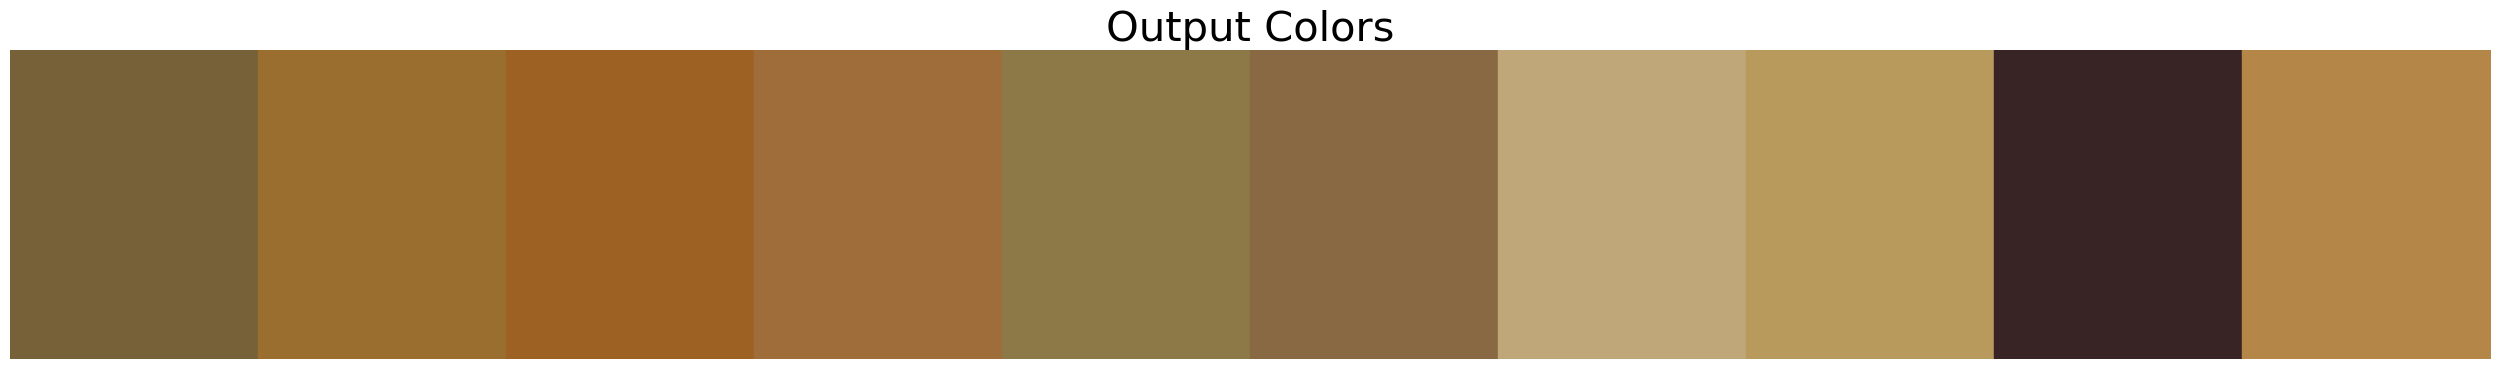

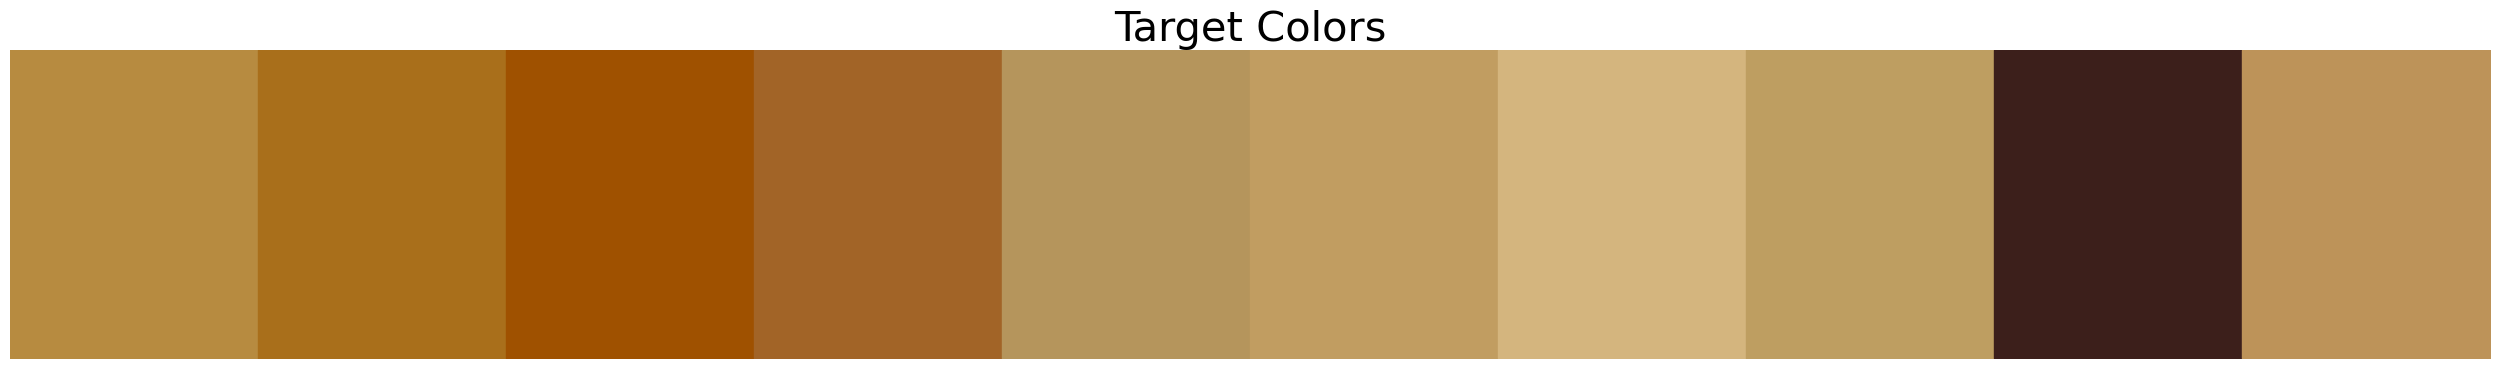

In [7]:
def plot_rgb_blocks(color_list, title, max_colors=None):
    if max_colors is not None:
        color_list = color_list[:max_colors]  # Slice the list to include only the specified number of colors

    plt.figure(figsize=(max(32, len(color_list)), 4))  # Adjust figure width dynamically
    for i, color in enumerate(color_list):
        color_rgb = np.clip(color, 0, 1)  # Ensure values are between 0 and 1
        plt.fill_between([i, i + 1], 0, 1, color=color_rgb)
        
    plt.xlim(0, len(color_list))
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

#output_colors_unnorm = unnormalize(output_colors[4], mean_value, std_value)
#target_colors_unnorm = unnormalize(target_colors[4], mean_value, std_value)

# Plot output and target color
plot_rgb_blocks(convert(output_colors[0]), "Output Colors",max_colors = 10)
plot_rgb_blocks(convert(target_colors[0]), "Target Colors",max_colors = 10)

In [15]:
df = pd.read_csv(path_df)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/T7 Shield/AntProject/colour_ants.csv'

In [80]:
mean_value = [0.485, 0.456, 0.406]
std_value= [0.229, 0.224, 0.225]

df = pd.read_csv(path_df)
df_rgb = get_bodypart_rgb_values(df, 'thorax')

specimen_set = set(df['specimen'])  # Convert to a set for faster lookup

image_file_names = read_image_file_names(images_dir)

image_file_set = set(image_file_names)

# Filter the DataFrame by checking if 'original_file' is in image_file_set
filtered_df = df_rgb[df_rgb['original_file'].isin(image_file_set)]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

train_ratio = 0.8
val_ratio = 0.1
val_dataset = ImageLabelDataset(images_dir,filtered_df,train_ratio,val_ratio,transform, split='val')


File is empty: /Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg


In [81]:
print(len(val_dataset))

2876


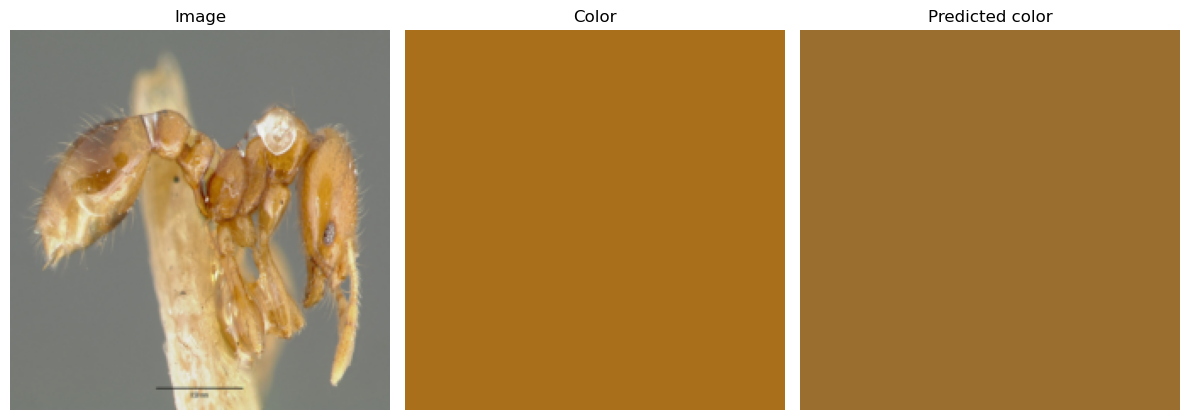

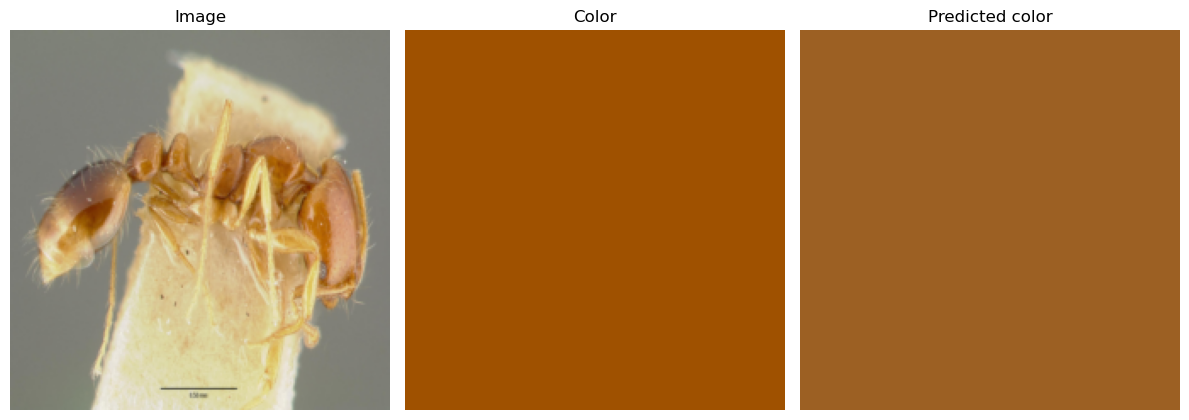

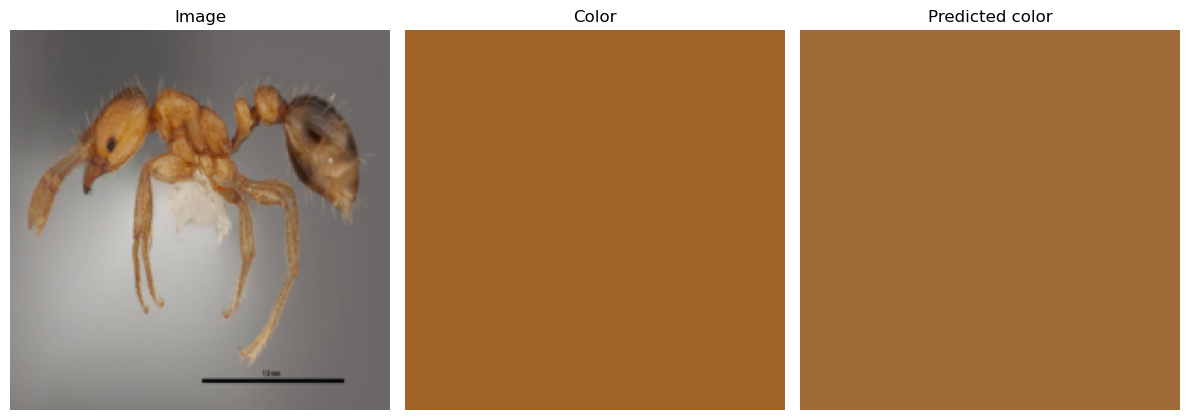

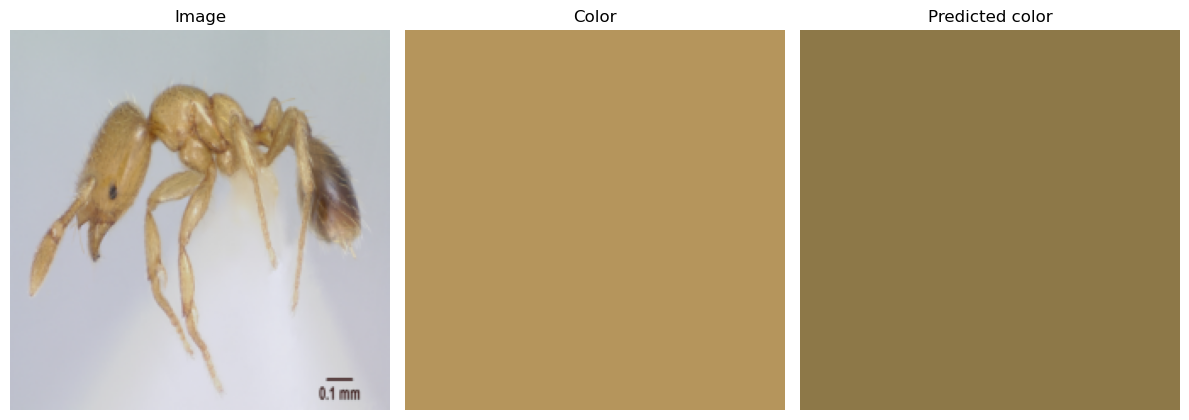

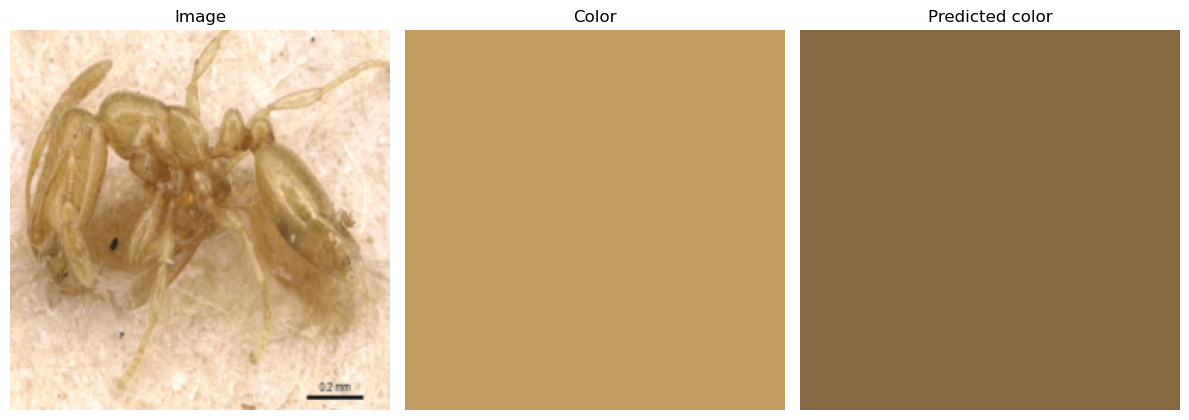

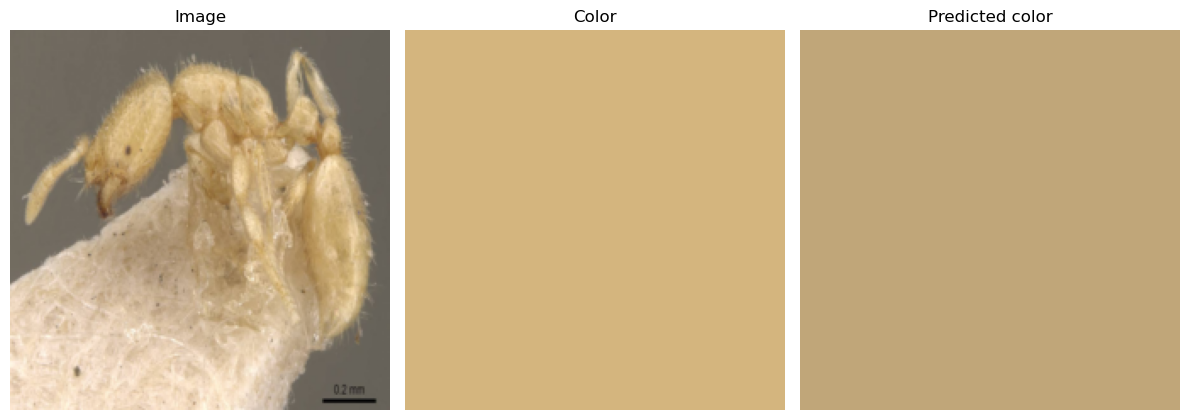

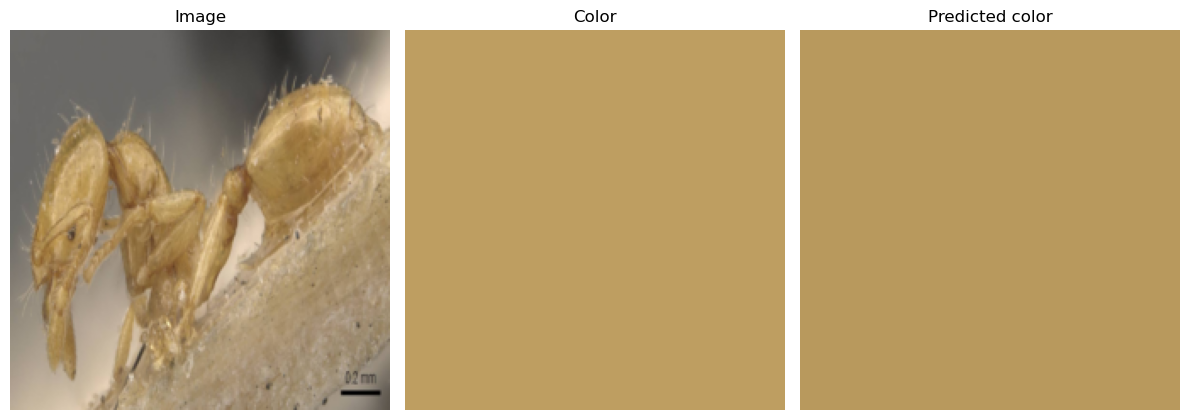

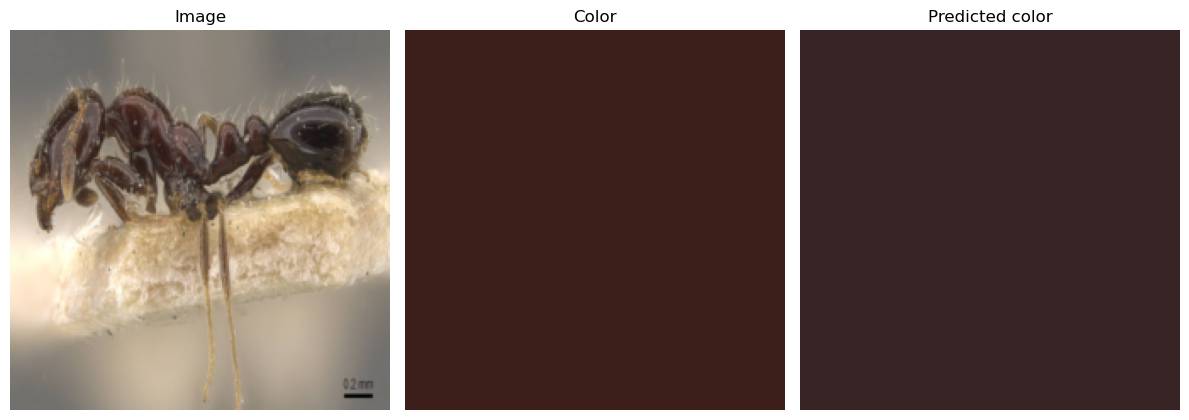

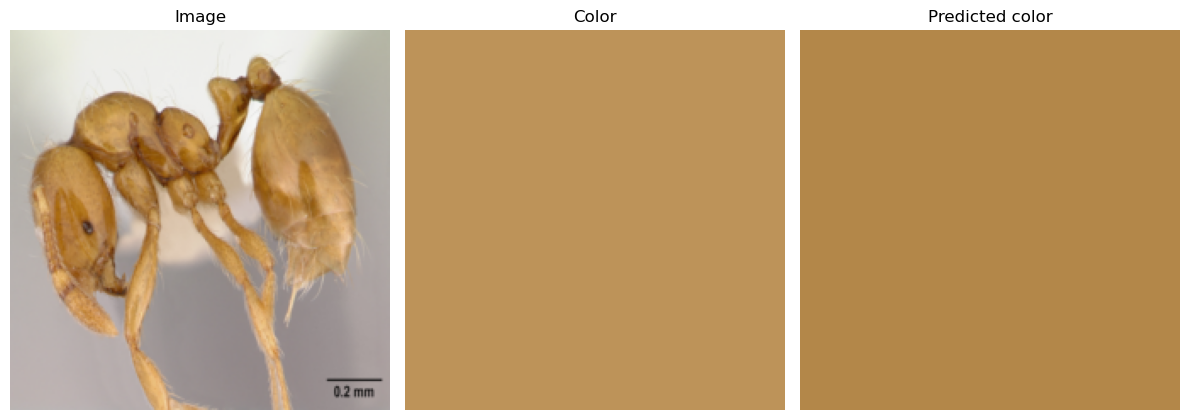

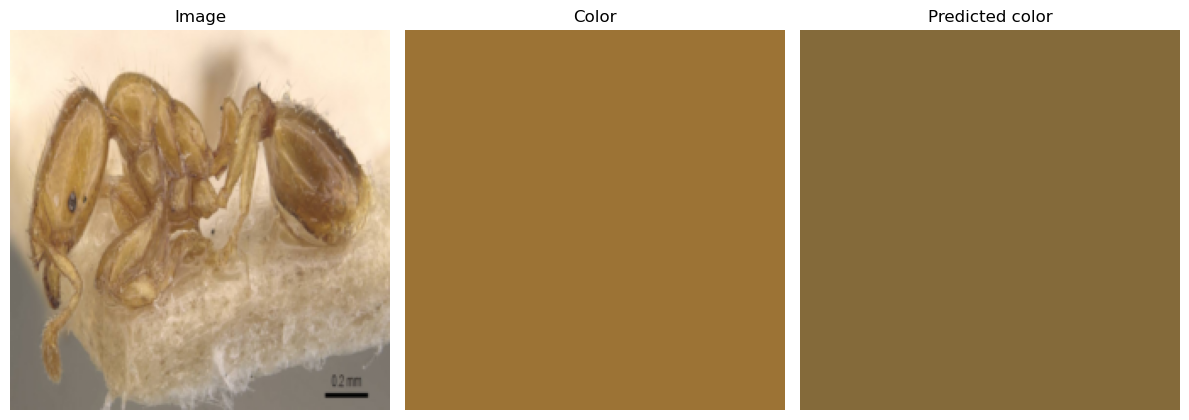

In [82]:
output_colors_np = convert(output_colors[0])

for i, (img, label) in enumerate(val_dataset):

    if i > 0:
        index = i #- 511
        # Convert tensors to numpy arrays for visualization
        img_np = img.permute(1, 2, 0).numpy()

        label = label.numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Image")
        ax[0].axis("off")

        rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(label)
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[index]
        
        ax[1].imshow(rgb_image)
        ax[1].set_title("Color")
        ax[1].axis("off")

        ax[2].imshow(rgb_target)
        ax[2].set_title("Predicted color")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

        if i == 10:
            break

Try runing model without standardizing the data!

### Plot evaluation matrics

In [83]:
def convert_values_to_numpy(output_tensor):
    output_np = []
    for batch in output_tensor:
        for value in batch:
            output_np.append(value.numpy())

    return np.array(output_np)

In [84]:
target_colors_np = convert_values_to_numpy(target_colors)
output_colors_np = convert_values_to_numpy(output_colors)

#se = np.sum((target_colors_np - output_colors_np), axis = 1) ** 2
euclidian_distance = np.sum((target_colors_np - output_colors_np)** 2, axis = 1)
mean_euclidian_distance = np.sum((target_colors_np- output_colors_np)**2, axis = 1)/3
test = np.mean(mean_euclidian_distance)

print(test)


0.008522528


In [85]:
print(len(val_dataset))
print(len(target_colors_np))

2876
2876


In [86]:
from torch import nn
criterion = nn.MSELoss()

loss = 0 
for i in range(0,len(target_colors)):
    loss += criterion(target_colors[i], output_colors[i])

print(loss/len(target_colors))

tensor(0.0084)


In [87]:
print(loss)

tensor(0.1014)


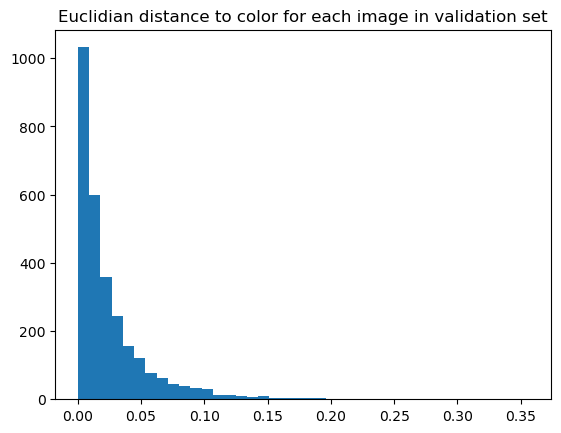

In [88]:
plt.hist(euclidian_distance, bins = 40)
#plt.yscale('log')
plt.title('Euclidian distance to color for each image in validation set')
plt.show()

In [89]:
#Mean square error per color channel
ed_sorted_index = np.argsort(euclidian_distance)
ed_sorted = np.sort(euclidian_distance)

In [90]:
print(len(euclidian_distance))

2876


In [91]:
lowest_10_indices = ed_sorted_index[:10]
highest_10_indices = ed_sorted_index[-10:]

In [92]:
def plot_colors_with_subplots(target_colors_np, output_colors_np, indices):
    # Initialize arrays for all target and output color rows
    all_target_colors = []
    all_output_colors = []

    for idx in indices:
        # Create a single row of 10x10 blocks for the target and output colors
        target_block = np.ones((10, 10, 3), dtype=float) * target_colors_np[idx]
        output_block = np.ones((10, 10, 3), dtype=float) * output_colors_np[idx]

        # Append the block to respective lists
        all_target_colors.append(target_block)
        all_output_colors.append(output_block)

    # Combine all blocks for each row into horizontal arrays
    target_row = np.hstack(all_target_colors)  # Horizontal stack for targets
    output_row = np.hstack(all_output_colors)  # Horizontal stack for outputs

    # Create the figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(len(indices), 4))
    # Plot target colors in the first subplot
    axs[0].imshow(target_row)
    axs[0].axis("off")
    axs[0].set_title("Target Colors")
    # Plot output colors in the second subplot
    axs[1].imshow(output_row)
    axs[1].axis("off")
    axs[1].set_title("Output Colors")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()




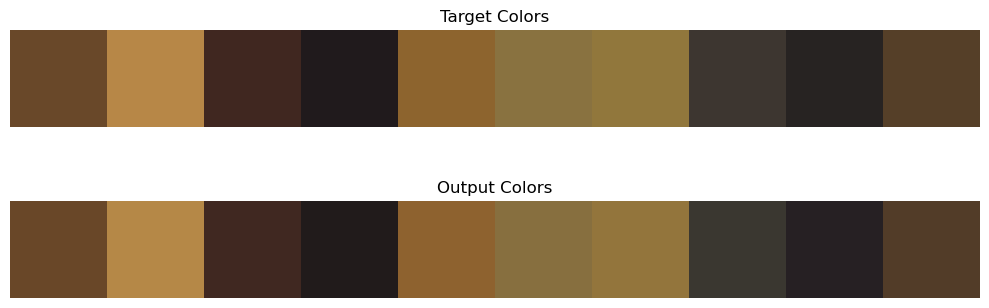

In [93]:
plot_colors_with_subplots(target_colors_np, output_colors_np, lowest_10_indices)

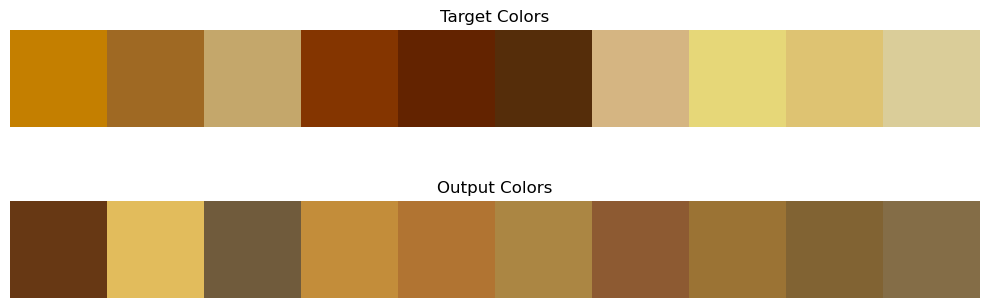

In [94]:
plot_colors_with_subplots(target_colors_np, output_colors_np, highest_10_indices)

In [197]:
def plot_colors(target_colors_np,output_colors_np, index):

    for i in range(0,len(index)):
        fig, ax = plt.subplots(1, 2, figsize=(2, 2))
        rgb_image = np.ones((10, 10, 3), dtype=int) * target_colors_np[index[i]]
        rgb_target = np.ones((10, 10, 3), dtype=int) * output_colors_np[index[i]]

        ax[0].imshow(rgb_image)
        ax[0].set_title("Color")
        ax[0].axis("off")

        ax[1].imshow(rgb_target)
        ax[1].set_title("Predicted color")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()



In [198]:
target_colors_np

array([[0.7176471 , 0.54509807, 0.2509804 ],
       [0.6627451 , 0.43529412, 0.10588235],
       [0.62352943, 0.31764707, 0.        ],
       ...,
       [0.33333334, 0.24705882, 0.15686275],
       [0.5176471 , 0.34901962, 0.21176471],
       [0.52156866, 0.34509805, 0.23137255]], dtype=float32)

### Plot colors

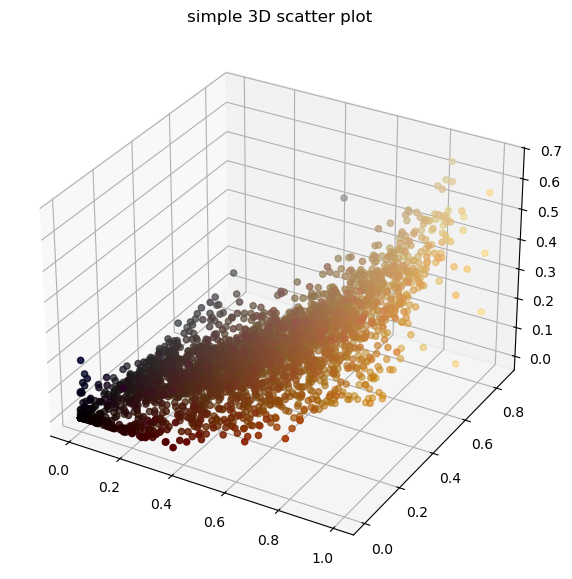

In [68]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2]))

# Creating plot
ax.scatter3D(target_colors_np[:,0], target_colors_np[:,1], target_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [69]:
output_colors_np

out_of_bounds = (output_colors_np < 0) | (output_colors_np > 1)

if np.any(out_of_bounds):
    print("Some values are out of bounds. Clipping them to the range [0, 1].")
    output_colors_np = np.clip(output_colors_np, 0, 1)
else:
    print("All values are within the range [0, 1].")


All values are within the range [0, 1].


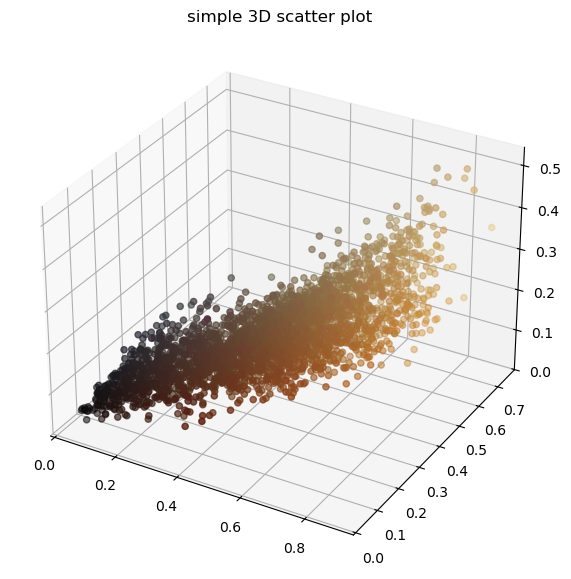

In [70]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2]))

# Creating plot
ax.scatter3D(output_colors_np[:,0], output_colors_np[:,1], output_colors_np[:,2], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

I feel like the prediction looks "linear". Maybe add another layer. The fully connected layer can only produce inear functions??

### Trying to find the represatentative pixel:

In [71]:
def find_representative_pixel(image, rgb_target, rgb_output):
    min_distance_target = 0.00005
    min_distance_output = 0.00005

    min_target_px = []
    min_target_py = []
    min_output_px = []
    min_output_py = []

    for py in range(0,223):
        for px in range(0,223):
            image_color = (image[py][px][0],image[py][px][1],image[py][px][2])
            distance_target = np.mean((image_color - rgb_target)**2)
            distance_output = np.mean((image_color - rgb_output)**2)

            if distance_target < min_distance_target:
                #min_distance_target = distance_target
                min_target_px.append(px)
                min_target_py.append(py)
            
            if distance_output < min_distance_output:
                #min_distance_output = distance_output
                min_output_px.append(px)
                min_output_py.append(py)

    return min_target_px,min_target_py,min_distance_target,min_output_px,min_output_py, min_distance_output

In [72]:
index = 20

for i, (img, label) in enumerate(val_dataset):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))

    if i == index:
        break

In [73]:
image.shape

(224, 224, 3)

In [74]:
min_target_px,min_target_py,min_distance_target,min_output_px,min_output_py, min_distance_output = find_representative_pixel(image, target_colors_np[index], output_colors_np[index])

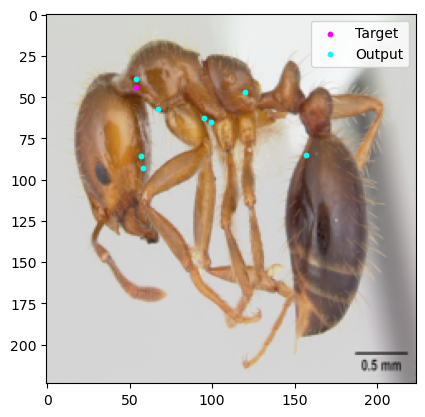

In [75]:
plt.imshow(image)

# Mark the target pixel with magenta
plt.scatter(min_target_px, min_target_py, color='magenta', label='Target', s=10)

# Mark the output pixel with cyan
plt.scatter(min_output_px, min_output_py, color='cyan', label='Output', s=10)

# Adding legend for clarity
plt.legend()